In [1]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')



In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
main_data=pd.read_csv("/content/drive/MyDrive/data/train (2).csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


,count
label,
0,29720
1,2242


0s : 1s  ::   13.26 : 1


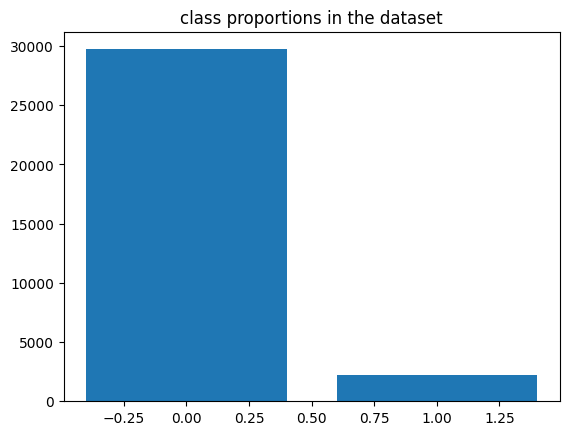

In [4]:
#Check class distribution in dependent variable
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

#### we see that we have an unbalanced data mojority class to minority class ratio of 13 : 1

,count
label,
0,29720
1,6726


0s : 1s  ::   4.42 : 1


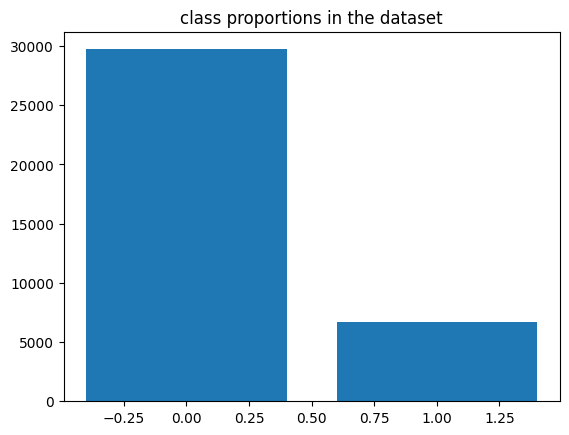

In [5]:
#Balancing the dataset using Oversampling
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1,data1], axis=0)
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [6]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)


def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))])

    return text2.lower()

In [7]:
#preprocess train dataset
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split()))

train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [8]:
#classes proportion in dependent variable in train and test dataset
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
label
0    23788
1     5368
Name: count, dtype: int64
29156
===========Test Data =========
label
0    5932
1    1358
Name: count, dtype: int64
7290


In [9]:
#train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:23324
Class distributionCounter({0: 19030, 1: 4294})
Valid data len:5832
Class distributionCounter({0: 4758, 1: 1074})


In [10]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [11]:
# Convert sentences to sequences (do not convert to NumPy array yet)
x_train_seq = tokenizer.texts_to_sequences(X_train)
x_valid_seq = tokenizer.texts_to_sequences(X_valid)
x_test_seq  = tokenizer.texts_to_sequences(test_data['tweet'].tolist())

# Padding
maxlen = 50
x_train = pad_sequences(x_train_seq, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid_seq, padding='post', maxlen=maxlen)
x_test  = pad_sequences(x_test_seq,  padding='post', maxlen=maxlen)

# Convert labels to numpy arrays
train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels  = np.asarray(test_data['label'].tolist())

# Print info
print('Train data len:', len(x_train))
print('Class distribution:', Counter(train_labels))
print('Validation data len:', len(x_valid))
print('Class distribution:', Counter(valid_labels))
print('Test data len:', len(x_test))
print('Class distribution:', Counter(test_labels))

# TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, test_labels))


Train data len: 23324
Class distribution: Counter({np.int64(0): 19030, np.int64(1): 4294})
Validation data len: 5832
Class distribution: Counter({np.int64(0): 4758, np.int64(1): 1074})
Test data len: 7290
Class distribution: Counter({np.int64(0): 5932, np.int64(1): 1358})


In [12]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[ 1501  8071 12469  1501   269    19     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[ 49 906 484  70   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Test dataset ====
tf.Tensor(
[135 111  17 494   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int32) tf.Tensor(0, shape=()

In [13]:
#model preparation
max_features =50000
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))




model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - binary_accuracy: 0.7303 - loss: 3.7709 - val_binary_accuracy: 0.8158 - val_loss: 1.5461
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - binary_accuracy: 0.8149 - loss: 1.2979 - val_binary_accuracy: 0.8158 - val_loss: 0.7808
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - binary_accuracy: 0.8142 - loss: 0.7633 - val_binary_accuracy: 0.8158 - val_loss: 0.6258
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - binary_accuracy: 0.8151 - loss: 0.6445 - val_binary_accuracy: 0.8553 - val_loss: 0.5071
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - binary_accuracy: 0.8586 - loss: 0.5498 - val_binary_accuracy: 0.9276 - val_loss: 0.3873
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - binary_accuracy: 0.9261 - loss: 0.4580 - val_binary_accuracy: 0.9448 - val_loss: 0.3415
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - binary_accuracy: 0.9487 - loss: 0.4073 - val_binary_accuracy: 0.9561 - val_loss: 0.3034
Epoch

In [15]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
[[1.5472650e-03]
 [9.8058355e-01]
 [9.5768428e-01]
 [4.5103710e-03]
 [1.9620946e-01]
 [9.5730603e-01]
 [7.1180967e-04]
 [1.9535162e-03]
 [1.5572736e-03]
 [9.8940641e-01]]


In [17]:
# Convert test tweets to sequences
x_test = tokenizer.texts_to_sequences(test_data['tweet'].tolist())

# Pad sequences to the same length
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

#Generate predictions for all samples
predictions = model.predict(x_test)

228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


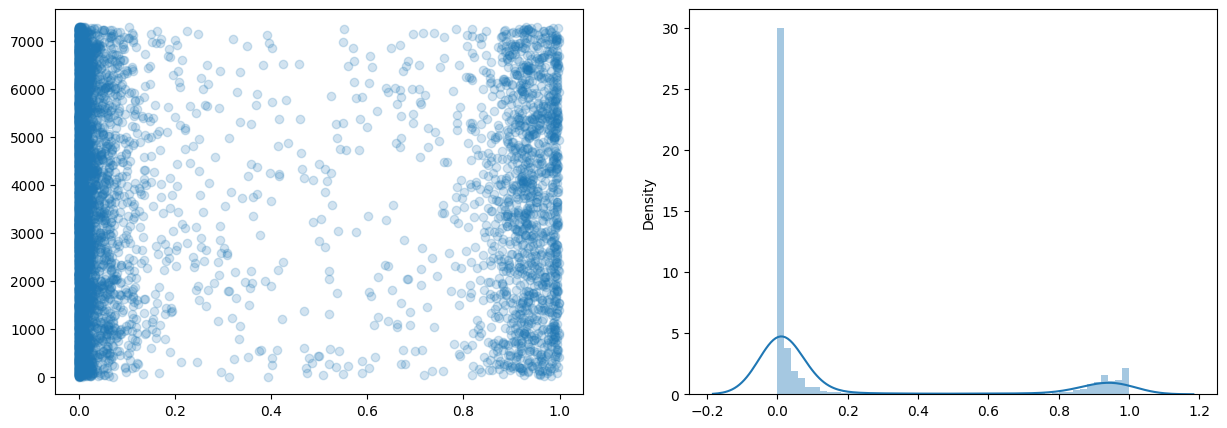

In [18]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

#### A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied

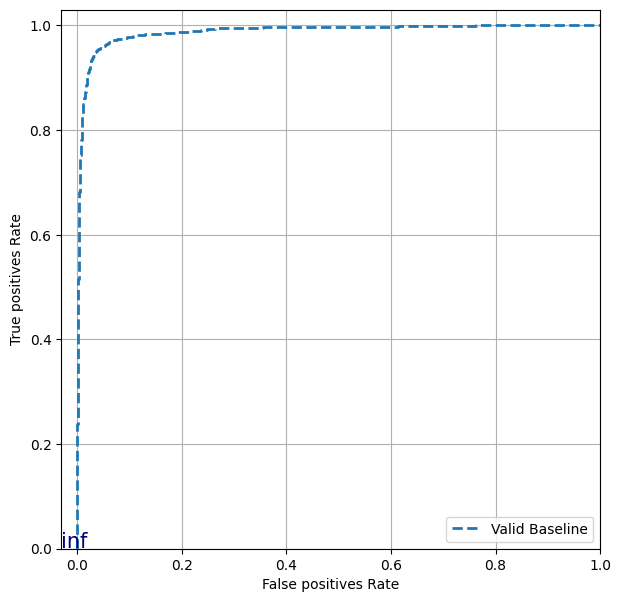

In [19]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [20]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5932
           1       0.93      0.84      0.88      1358

    accuracy                           0.96      7290
   macro avg       0.95      0.91      0.93      7290
weighted avg       0.96      0.96      0.96      7290



## TESTING MODEL ON THE TEST DATASET PROVIDED

In [24]:
final_test = pd.read_csv("/content/drive/MyDrive/data/test.csv")
ftest = final_test.copy()
ftest.drop(columns=['id'], axis=1, inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test = tokenizer.texts_to_sequences(ftest['tweet'].tolist())  # no np.array here!
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display(x_test)
display(f_test)


array([[ 135,  111,   17, ...,    0,    0,    0],
       [1492,   61, 9186, ...,    0,    0,    0],
       [   7,  138,  193, ...,    0,    0,    0],
       ...,
       [   2,    2,  955, ...,    0,    0,    0],
       [   2,    2, 1067, ...,    0,    0,    0],
       [  21,    2,    1, ...,    0,    0,    0]], dtype=int32)

array([[ 9565,     1, 30151, ...,     0,     0,     0],
       [    2,    55, 20174, ...,     0,     0,     0],
       [  466,   827,   730, ...,     0,     0,     0],
       ...,
       [    9,    32,   333, ...,     0,     0,     0],
       [  312,   673,   123, ...,     0,     0,     0],
       [  270,   946, 11665, ...,     0,     0,     0]], dtype=int32)

In [25]:
#predict on actual test data
predictions = model.predict(f_test)

538/538 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step


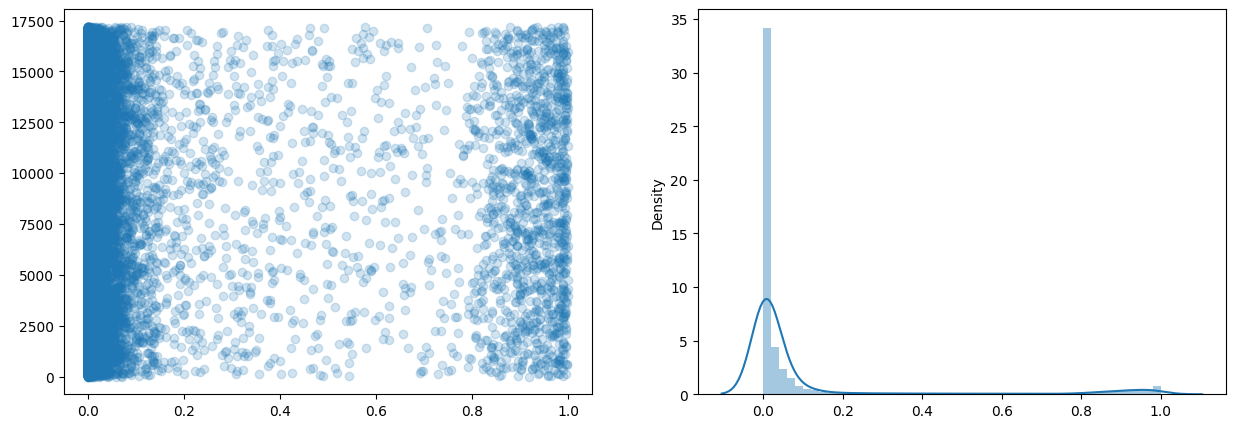

In [26]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.2)
ax2=sns.distplot(predictions)

In [27]:
#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]

,tweet,pred_sentiment
1,user white supremacists want everyone birdsâ movie hereâs,1.0
19,thought factory neutrality right wing fascism politics media brexit trump leadership,1.0
26,chick gets fucked hottest naked lady,1.0
33,suppo taiji fisherman bullying racism tweet4taiji thecove seashepherd,1.0
42,user user trumps invested billions into saudi empowers people funding isis trumpsahypocrite,1.0
...,...,...
17148,grew fucked upð¤ fucked upð¥ believing better place fucking upð© âï¸,1.0
17176,user user most racist ever,1.0
17188,black professor demonizes proposes nazi style confiscation white assets like 1930s germany breaking,1.0
17192,thought factory leftright polarisation trump uselections2016 leadership politics brexit,1.0


In [28]:
#actual tweets categorized as hate speech
final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

,id,tweet
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
19,31982,thought factory: bbc neutrality on right wing fascism #politics #media #blm #brexit #trump #leadership &gt;3
26,31989,chick gets fucked hottest naked lady
33,31996,suppo the #taiji fisherman! no bullying! no racism! #tweet4taiji #thecove #seashepherd
42,32005,@user @user trumps invested billions into saudi. he empowers the people funding isis. #trumpsahypocrite
...,...,...
17148,49111,we grew up fucked upð¤ its fucked upð¥ i'm believing you in a better place but it's fucking me upð© Ã¨ âï¸
17176,49139,@user @user are the most racist pay ever!!!!!
17188,49151,"black professor demonizes, proposes nazi style confiscation of ""white"" assets; like 1930's germany #breaking"
17192,49155,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
